## estudo do percentual de despesas das clínicas AmorSaúde

In [2]:
# importanto bibliotecas
import pandas as pd
import numpy as np
import psycopg2

#pacotes gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#pacotes de modelagem
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
# conexão redshift 
connection = psycopg2.connect(dbname="dw_amorsaude",

                  user="lucasmateus",

                  password="df93aS@aK0sd",

                  host ="amorsaude-cluster-redshift.cmc4ev2oyczd.us-east-1.redshift.amazonaws.com",

                  port = 5439)

In [4]:
# definição queries
query_despesa = """
--***DRE AMORSAUDE***
with periodo as (
	select 
		date_trunc('month', p.data) as data, 
		count(*) 
	from stg_periodo p 
	where p.data <= date_trunc('month', current_date) - interval '1 month'
	group by 
		date_trunc('month', p.data)),	
faturamento_bruto as (
	select 
		rb.id_unidade as id, 
		p.data, 
		sum(rb.total_recebido) as faturamento_bruto 
	from periodo p
	left join tb_consolidacao_receita_bruta_hist_final rb
	on p.data = date_trunc('month', rb."data")
	--where rb.id_unidade = 19647
	group by 
		rb.id_unidade, 
		p.data),
despesa_bruta as (
	select 
		cp.id, 
		p.data, 
		case when cp.subcategoria in ('Royalties','Royalties (Split)') then 'Royalties' 
		else cp.categoria end categoria, 
		cp.subcategoria, 
		sum(cp.valorpago) as despesa_bruta
	from periodo p
	left join tb_consolidacao_contas_a_pagar_hist cp
	on p.data = date_trunc('month', cp.datapagamento)
	where cp.situacaoconta <> 'Em aberto'
	--and cp.id = 19647
	group by 
		cp.id, 
		p.data, 
		cp.categoria, 
		cp.subcategoria),
royalties as (
	select 
		db.id, 
		db."data", 
		case when sum(db.despesa_bruta) is null then 0 
		else sum(db.despesa_bruta) end as royalties
	from despesa_bruta db
	where db.subcategoria = 'Royalties'
	group by 
		db.id, 
		db."data"),
royalties_split as (
	select 
		db.id, 
		db."data", 
		case when sum(db.despesa_bruta) is null then 0 
		else sum(db.despesa_bruta) end as royalties_split
	from despesa_bruta db
	where db.subcategoria = 'Royalties (Split)'
	group by 
		db.id, 
		db."data"),
repasse_consultas as (
	select 
		db.id, 
		db."data", 
		sum(db.despesa_bruta) as repasse_consultas
	from despesa_bruta db
	where db.categoria = 'Repasse de Consultas'
	group by 
		db.id, 
		db."data"),
repasse_exames as (
	select 
		db.id, 
		db."data", 
		case when sum(db.despesa_bruta) is null then 0
		else sum(db.despesa_bruta) end as repasse_exames
	from despesa_bruta db
	where db.categoria = 'Repasse de Exames'
	group by 
		db.id, 
		db."data"),
repasse_procedimentos as (
	select 
		p."data", 
		db.id, 
		nvl(sum(db.despesa_bruta), 0) as repasse_procedimentos
	from periodo p
	left join despesa_bruta db on p.data = db.data
	where db.categoria = 'Repasse De Procedimentos'
	group by 
		db.id, 
		p."data"),
repasses as (
	select 
		db.id, 
		db."data", 
		case when sum(db.despesa_bruta) is null then 0
		else sum(db.despesa_bruta) end as repasses
	from despesa_bruta db
	where db.categoria = 'Repasses'
	--and db.subcategoria is null
	group by 
		db.id, 
		db."data"),
repasse_profissional as (
	select distinct 
		db.data, 
		db.id, 
		rc.repasse_consultas, 
		re.repasse_exames, 
		rp.repasse_procedimentos, 
		rep.repasses,
		(nvl(rc.repasse_consultas, 0) + nvl(re.repasse_exames, 0) + nvl(rp.repasse_procedimentos, 0) + nvl(rep.repasses, 0)) as repasse_profissional
	from despesa_bruta db
	left join repasse_consultas rc on db.data = rc.data and db.id = rc.id
	left join repasse_exames re on db.data = re.data and db.id = re.id
	left join repasse_procedimentos rp on db.data = rp.data and db.id = rp.id
	left join repasses rep on db.data = rep.data and db.id = rep.id),
margem_op as (
	select 
		fb.id, 
		fb.data, 
		nvl(fb.faturamento_bruto, 0) as faturamento_bruto, nvl(ro.royalties, 0) as royalties, 
		nvl(rs.royalties_split, 0) as royalties_split,
		nvl(rp.repasse_profissional) as repasse_profissional,
		(nvl(fb.faturamento_bruto, 0) - nvl(ro.royalties, 0) + nvl(rs.royalties_split, 0) - nvl(rp.repasse_profissional)) as margem_op --royalties_split adicionado pois valor consta como negativo
	from faturamento_bruto fb
	left join royalties ro on fb.id = ro.id and fb.data = ro.data
	left join royalties_split rs on fb.id = rs.id and fb.data = rs.data
	left join repasse_profissional rp on fb.id = rp.id and fb.data = rp.data
	),
despesa_medicos as (
	select 
		db.id, 
		db."data", 
		case when sum(db.despesa_bruta) is null then 0 
		else sum(db.despesa_bruta) end as despesa_medicos
	from despesa_bruta db
	where db.categoria = 'Despesas com Médicos'
	group by 
		db.id, 
		db."data"),
despesa_lab as (
	select 
		db.id, 
		db."data", 
		case when sum(db.despesa_bruta) is null then 0 
		else sum(db.despesa_bruta) end as despesa_lab
	from despesa_bruta db
	where db.categoria in ('Despesas Com Laboratórios', 'Despesa com Laboratórios')
	group by 
		db.id, 
		db."data"),
despesa_outrosp as (
	select 
		db.id, 
		db."data", 
		case when sum(db.despesa_bruta) is null then 0 
		else sum(db.despesa_bruta) end as despesa_outrosp
	from despesa_bruta db
	where db.categoria = 'Despesas com Outros Profissionais'
	group by 
		db.id, 
		db."data"),
despesa_funcionarios as (
	select 
		db.id, 
		db."data", 
		case when sum(db.despesa_bruta) is null then 0 
		else sum(db.despesa_bruta) end as despesa_funcionarios
	from despesa_bruta db
	where db.categoria = 'Funcionários'
	group by 
		db.id, 
		db."data"),
despesa_impostos as (
	select 
		db.id, 
		db."data", 
		case when sum(db.despesa_bruta) is null then 0 
		else sum(db.despesa_bruta) end as despesa_impostos
	from despesa_bruta db
	where db.categoria = 'Impostos'
	group by 
		db.id, 
		db."data"),
despesa_adm as (
	select 
		db.id, 
		db."data", 
		case when sum(db.despesa_bruta) is null then 0 
		else sum(db.despesa_bruta) end as despesa_adm
	from despesa_bruta db
	where db.categoria = 'Administrativas'
	group by 
		db.id, 
		db."data"),
despesa_total as (
	select distinct 
		db.data, 
		db.id,
	nvl(dm.despesa_medicos, 0) despesa_medicos, 
	nvl(dl.despesa_lab, 0) despesa_lab, 
	nvl(dop.despesa_outrosp, 0) despesa_outrosp, 
	nvl(df.despesa_funcionarios, 0) despesa_funcionarios, 
	nvl(di.despesa_impostos, 0) despesa_impostos, 
	nvl(da.despesa_adm, 0) despesa_adm,
	(nvl(dm.despesa_medicos, 0) + nvl(dl.despesa_lab, 0) + nvl(dop.despesa_outrosp, 0) + nvl(df.despesa_funcionarios, 0) + nvl(di.despesa_impostos, 0) + nvl(da.despesa_adm, 0)) as despesa_total
	from despesa_bruta db
	left join despesa_medicos dm on db.data = dm.data and db.id = dm.id
	left join despesa_lab dl on db.data = dl.data and db.id = dl.id
	left join despesa_outrosp dop on db.data = dop.data and db.id = dop.id
	left join despesa_funcionarios df on db.data = df.data and db.id = df.id
	left join despesa_impostos di on db.data = di.data and db.id = di.id
	left join despesa_adm da on db.data = da.data and db.id = da.id),
resultado_operacional as (
	select 
		mo.data, 
		mo.id, 
		nvl(mo.margem_op, 0) margem_op, 
		nvl(dt.despesa_total, 0) despesa_total, 
		(nvl(mo.margem_op, 0) - nvl(dt.despesa_total, 0)) resultado_operacional 
	from margem_op mo
	left join despesa_total dt on mo.data = dt.data and mo.id = dt.id),
receita_financeira as (
	select 
		cr.id_unidade as id, 
		cr.nome_unidade, 
		p.data, 
		sum(cr.valor_pago) as receita_financeira 
	from periodo p
	left join tb_consolidacao_contas_a_receber_modelagem cr
	on p.data = date_trunc('month', cr."data")
	where cr.situacaoconta is not null
	and cr.categoria = 'Receitas Financeiras'
	--and cr.id_unidade = 19849
	--and date(cr."data") between date('2023-01-01') and date('2023-05-31')
	group by 
		cr.id_unidade, 
		cr.nome_unidade, 
		p.data),
investimentos_pg as (
	select 
		db.id, 
		db."data", 
		case when sum(db.despesa_bruta) is null then 0
		else sum(db.despesa_bruta) end as investimentos_pg
	from despesa_bruta db
	where db.categoria = 'Investimentos'
	group by 
		db.id, 
		db."data"),
despesa_financeira as (
	select 
		db.id, 
		db."data", 
		case when sum(db.despesa_bruta) is null then 0 
		else sum(db.despesa_bruta) end as despesa_financeira
	from despesa_bruta db
	where db.categoria = 'Financeiras'
	group by 
		db.id, 
		db."data"),
outras_despesas as (
	select 
		db.id, 
		db."data", 
		case when sum(db.despesa_bruta) is null then 0 
		else sum(db.despesa_bruta) end as outras_despesas
	from despesa_bruta db
	where db.categoria = 'Outras Despesas'
	group by 
		db.id, 
		db."data"),
resultado_exercicio as (
	select 
		fb.id, 
		fb.data, 
		rop.resultado_operacional, 
		rf.receita_financeira, 
		ipg.investimentos_pg, 
		df.despesa_financeira, 
		oup.outras_despesas, 
	nvl(nvl(rop.resultado_operacional, 0) - nvl(ipg.investimentos_pg, 0) + nvl(rf.receita_financeira, 0) - nvl(df.despesa_financeira, 0) - nvl(oup.outras_despesas, 0), 0) as resultado_exercicio
	from faturamento_bruto fb
	left join resultado_operacional rop on fb.id = rop.id and fb."data" = rop.data
	left join receita_financeira rf on rf.id = fb.id and rf.data = fb.data
	left join investimentos_pg ipg on ipg.id = fb.id and ipg.data = fb.data
	left join despesa_financeira df on df.id = fb.id and df.data = fb.data
	left join outras_despesas oup on oup.id = fb.id and oup.data = fb.data),
despesa_socios as (
	select 
		db.id, 
		db."data", 
		case when sum(db.despesa_bruta) is null then 0 
		else sum(db.despesa_bruta) end as despesa_socios
	from despesa_bruta db
	where db.categoria = 'Sócios'
	group by 
		db.id, 
		db."data"),
receita_socios as (
	select 
		cr.id_unidade as id, 
		cr.nome_unidade, 
		p.data, 
		sum(cr.valor_pago) as receita_socios 
	from periodo p
	left join tb_consolidacao_contas_a_receber_modelagem cr on p.data = date_trunc('month', cr."data")
	where cr.situacaoconta is not null
	and cr.categoria = 'Sócios'
	--and cr.id_unidade = 19849
	--and date(cr."data") between date('2023-01-01') and date('2023-05-31')
	group by 
		cr.id_unidade, 
		cr.nome_unidade, 
		p.data),
ajustes_entrada as (
	select 
		cr.id_unidade as id, 
		cr.nome_unidade, 
		p.data, 
		sum(cr.valor_pago) as ajustes_entrada 
	from periodo p
	left join tb_consolidacao_contas_a_receber_modelagem cr on p.data = date_trunc('month', cr."data")
	where cr.situacaoconta is not null
	and cr.subcategoria = 'Ajustes - Entradas'
	--and cr.id_unidade = 19849
	--and date(cr."data") between date('2023-01-01') and date('2023-05-31')
	group by 
	cr.id_unidade, 
	cr.nome_unidade, 
	p.data),
ajustes_saida as (
	select 
		db.id, 
		db."data", 
		case when sum(db.despesa_bruta) is null then 0
		else sum(db.despesa_bruta) end as ajustes_saida
	from despesa_bruta db
	where db.categoria = 'Ajustes - Saídas'
	group by 
		db.id, 
		db."data"),
resultado_liquido as (
	select 
		fb.id, 
		fb.data, 
		nvl(re.resultado_exercicio, 0) resultado_exercicio, nvl(ds.despesa_socios, 0) despesa_socios, 
		nvl(rso.receita_socios, 0) receita_socios,
		nvl(ae.ajustes_entrada, 0) ajustes_entrada,
		nvl(asa.ajustes_saida, 0) ajustes_saida,
		nvl(nvl(re.resultado_exercicio, 0) - nvl(ds.despesa_socios, 0) + nvl(rso.receita_socios, 0) + nvl(ae.ajustes_entrada, 0) - nvl(asa.ajustes_saida, 0), 0) as resultado_liquido
	from faturamento_bruto fb
	left join resultado_exercicio re on re.id = fb.id and re.data = fb.data
	left join despesa_socios ds on ds.id = fb.id and ds.data = fb.data
	left join receita_socios rso on rso.id = fb.id and rso.data = fb.data
	left join ajustes_entrada ae on ae.id = fb.id and ae.data = fb.data
	left join ajustes_saida asa on asa.id = fb.id and asa.data = fb.data)
select
	fb.data,
	fb.id as id_unidade,
	un.nome_fantasia nome_unidade,
	sue.descricao regiao,
	fb.faturamento_bruto,
	ro.royalties royalties,
	rs.royalties_split, 
	rp.repasse_consultas repasse_consultas,
	rp.repasse_exames repasse_exames,
	rp.repasse_procedimentos repasse_procedimentos,
	rp.repasses repasses,
	mo.margem_op,
	dt.despesa_medicos despesa_medicos,
	dt.despesa_lab despesa_lab,
	dt.despesa_outrosp despesa_outrosp,
	dt.despesa_funcionarios despesa_funcionarios,
	dt.despesa_impostos despesa_impostos,
	dt.despesa_adm despesa_adm,
	dt.despesa_total despesa_total,
	rop.resultado_operacional,
	ipg.investimentos_pg investimentos_pg,
	rf.receita_financeira,
	df.despesa_financeira despesa_financeira,
	oup.outras_despesas outras_despesas,
	re.resultado_exercicio,
	rso.receita_socios,
	ds.despesa_socios despesa_socios,
	ae.ajustes_entrada,
	asa.ajustes_saida ajustes_saida,
	rl.resultado_liquido
from faturamento_bruto fb
left join royalties ro on fb.id = ro.id and fb."data" = ro.data
left join royalties_split rs on fb.id = rs.id and fb."data" = rs.data
left join repasse_profissional rp on fb.id = rp.id and fb."data" = rp.data
left join margem_op mo on fb.id = mo.id and fb."data" = mo.data
left join despesa_total dt on fb.id = dt.id and fb."data" = dt.data
left join resultado_operacional rop on fb.id = rop.id and fb."data" = rop.data
left join receita_financeira rf on rf.id = fb.id and rf.data = fb.data
left join investimentos_pg ipg on ipg.id = fb.id and ipg.data = fb.data
left join despesa_financeira df on df.id = fb.id and df.data = fb.data
left join outras_despesas oup on oup.id = fb.id and oup.data = fb.data
left join resultado_exercicio re on re.id = fb.id and re.data = fb.data
left join despesa_socios ds on ds.id = fb.id and ds.data = fb.data
left join receita_socios rso on rso.id = fb.id and rso.data = fb.data
left join resultado_liquido rl on rl.id = fb.id and rl.data = fb.data
left join ajustes_entrada ae on ae.id = fb.id and ae.data = fb.data
left join ajustes_saida asa on asa.id = fb.id and asa.data = fb.data
left join stg_unidades un on fb.id = un.id
left join stg_unidades_regioes sue on un.regiao_id = sue.id
order by fb.data
"""

query_apoio = """
with agendamentos_status as (
	select 
		date_trunc('month', ag.datadoatendimento) data, 
		ag.id_unidade, 
	case when ag.status_id in (33, 207, 202, 2, 200, 203, 5, 204, 201, 205, 4, 206, 3) then 'Atendido' 
	else 'Não compareceu' end status, 
	sum(ag.totalagendamentos) as qtd_agendamentos 
	from tb_consolidacao_agendamentos_hist ag
	group by 
		date_trunc('month', ag.datadoatendimento), 
		ag.id_unidade, 
		status),
agendamentos as (
	select 
		ags.data, 
		ags.id_unidade, 
		sum(ags.qtd_agendamentos) qtd_agendamentos
	from agendamentos_status ags
	group by 
		ags.data, 
		ags.id_unidade),
atendimentos as (
	select 
		ags.data, 
		ags.id_unidade, 
		ags.qtd_agendamentos as qtd_atendimentos 
	from agendamentos_status ags
	where ags.status = 'Atendido'),
meses_inauguracao as (
	select 
		ag.data, 
		ag.id_unidade, 
		months_between(ag.data, date_trunc('month', su.data_inauguracao)) as meses_inauguracao
	from agendamentos ag
	left join stg_unidades su on ag.id_unidade = su.id)
select 
	ag.data, 
	ag.id_unidade, 
	ag.qtd_agendamentos, 
	atd.qtd_atendimentos, 
	mi.meses_inauguracao
from agendamentos ag
left join atendimentos atd on ag.data = atd.data and ag.id_unidade = atd.id_unidade
left join meses_inauguracao mi on mi.data = ag.data and mi.id_unidade = ag.id_unidade
where ag.data < date_trunc('month', current_date)
order by ag.data"""

In [5]:
# setando o dataframe com despesas
df_d = pd.read_sql_query(query_despesa,con=connection)
df_d = df_d.fillna(0)

# exibindo o dataframe
df_d

/tmp/ipykernel_28055/2974510369.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_d = pd.read_sql_query(query_despesa,con=connection)


,data,id_unidade,nome_unidade,regiao,faturamento_bruto,royalties,royalties_split,repasse_consultas,repasse_exames,repasse_procedimentos,...,investimentos_pg,receita_financeira,despesa_financeira,outras_despesas,resultado_exercicio,receita_socios,despesa_socios,ajustes_entrada,ajustes_saida,resultado_liquido
0,2021-01-01,19276,AmorSaúde Curitiba Pinheirinho,Sul,197093.22,2523.76,0.00,26533.50,3727.00,0.0,...,15926.12,3.77,3123.84,720.2,-8243.87,0.00,0.00,0.0,0.00,-8243.87
1,2021-01-01,19443,AmorSaúde Guarapari,ES,276370.45,0.00,0.00,1952.00,51328.55,0.0,...,3237.34,22701.24,0.00,1036.0,32386.38,0.00,3000.00,0.0,0.00,29386.38
2,2021-01-01,19728,AmorSaúde Uberlândia,MG,139788.93,0.00,0.00,8228.67,13282.00,0.0,...,5083.42,0.00,96.00,70.0,38895.44,5000.00,0.00,0.0,0.00,43895.44
3,2021-01-01,19380,Clínica Pró Saúde (Linhares),ES,378015.38,1043.61,0.00,0.00,0.00,0.0,...,14843.88,0.00,3219.63,209.0,59697.02,0.00,0.00,0.0,0.00,59697.02
4,2021-01-01,19801,AmorSaúde Votuporanga,SP Interior,10033.00,0.00,0.00,25.00,60.00,0.0,...,4400.00,0.00,0.00,0.0,-23348.78,0.00,0.00,0.0,0.00,-23348.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11218,2023-07-01,19455,AmorSaúde Vitória,ES,652238.86,11894.18,-13296.87,0.00,0.00,0.0,...,7428.74,2041.84,7.00,2719.9,208918.99,25960.37,70988.10,0.0,651.00,163240.26
11219,2023-07-01,19891,AmorSaúde Camocim,NE2,92200.52,669.40,-144.46,0.00,0.00,0.0,...,0.00,0.00,0.00,0.0,35412.66,0.00,0.00,0.0,0.00,35412.66
11220,2023-07-01,19915,AmorSaúde Parauapebas,Norte,227999.96,1422.33,-2311.78,0.00,0.00,0.0,...,2564.32,0.00,401.30,468.6,62391.85,0.00,3600.00,0.1,68.00,58723.95
11221,2023-07-01,19385,Instituto Médico Caucaia (Caucaia),NE2,249997.50,5223.96,-3744.40,0.00,0.00,0.0,...,4512.60,0.00,12432.54,411.0,2600.03,15376.98,2996.37,0.0,198.48,14782.16


In [6]:
# setando dataframe com informações de apoio
df_ap = pd.read_sql_query(query_apoio, con=connection)

# exibindo o dataframe
df_ap

/tmp/ipykernel_28055/4088978366.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ap = pd.read_sql_query(query_apoio, con=connection)


,data,id_unidade,qtd_agendamentos,qtd_atendimentos,meses_inauguracao
0,2021-01-01,19626.0,2936,2118.0,20.0
1,2021-01-01,19404.0,5696,3627.0,29.0
2,2021-01-01,19289.0,4759,3108.0,5.0
3,2021-01-01,19358.0,10624,7387.0,5.0
4,2021-01-01,19727.0,1577,1077.0,5.0
...,...,...,...,...,...
11323,2023-07-01,19799.0,2720,1592.0,33.0
11324,2023-07-01,19908.0,2292,1311.0,20.0
11325,2023-07-01,19837.0,1693,1043.0,26.0
11326,2023-07-01,19802.0,972,582.0,33.0


In [7]:
# transformando colunas 'data' em datetime
df_d['data'] = pd.to_datetime(df_d['data'])
df_ap['data'] = pd.to_datetime(df_ap['data'])

In [8]:
# mesclando os dataframes
df_c = pd.merge(df_d, df_ap, on=['id_unidade', 'data'])

# exibindo colunas do novo df
df_c.columns

Index(['data', 'id_unidade', 'nome_unidade', 'regiao', 'faturamento_bruto',
       'royalties', 'royalties_split', 'repasse_consultas', 'repasse_exames',
       'repasse_procedimentos', 'repasses', 'margem_op', 'despesa_medicos',
       'despesa_lab', 'despesa_outrosp', 'despesa_funcionarios',
       'despesa_impostos', 'despesa_adm', 'despesa_total',
       'resultado_operacional', 'investimentos_pg', 'receita_financeira',
       'despesa_financeira', 'outras_despesas', 'resultado_exercicio',
       'receita_socios', 'despesa_socios', 'ajustes_entrada', 'ajustes_saida',
       'resultado_liquido', 'qtd_agendamentos', 'qtd_atendimentos',
       'meses_inauguracao'],
      dtype='object')

In [9]:
# criando colunas
df_c['despesas_agrupadas'] = df_c['despesa_funcionarios'] + df_c['despesa_impostos'] + df_c['despesa_adm']
df_c['%_agrupadas'] = (df_c['despesas_agrupadas'] / df_c['margem_op']).abs()
#df_c['%_agru_abx'] =  np.where(df_c['%_agrupadas'] <= 0.43, 'Sim', 'Não')
df_c['%_funcionarios'] = (df_c['despesa_funcionarios'] / df_c['margem_op']).abs()#*100
#df_c['%_func_abx'] =  np.where(df_c['%_funcionarios'] <= 0.17, 'Sim', 'Não')
df_c['%_adm'] = (df_c['despesa_adm'] / df_c['margem_op']).abs()#*100
#df_c['%_adm_abx'] =  np.where(df_c['%_adm'] <= 0.18, 'Sim', 'Não')
df_c['%_impostos'] = (df_c['despesa_impostos'] / df_c['margem_op']).abs()#*100
#df_c['%_imp_abx'] =  np.where(df_c['%_impostos'] <= 0.08, 'Sim', 'Não')
df_c['%_margem_op'] = (df_c['margem_op'] / df_c['faturamento_bruto']).abs()
#df_c['%_margem_acm'] = np.where(df_c['margem_op'] >= 0.5, 'Sim', 'Não')
df_c['%_resultado_op'] = (df_c['resultado_operacional'] / df_c['margem_op']).abs()
df_c['tx_conversao'] = (df_c['qtd_atendimentos'] / df_c['qtd_agendamentos']).abs()
df_c['lucratividade'] = (df_c['resultado_liquido'] / df_c['faturamento_bruto'])
#df_c['lucratividade_acm'] = np.where(df_c['lucratividade'] >= 0.25, 'Sim', 'Não')


df_c.columns

Index(['data', 'id_unidade', 'nome_unidade', 'regiao', 'faturamento_bruto',
       'royalties', 'royalties_split', 'repasse_consultas', 'repasse_exames',
       'repasse_procedimentos', 'repasses', 'margem_op', 'despesa_medicos',
       'despesa_lab', 'despesa_outrosp', 'despesa_funcionarios',
       'despesa_impostos', 'despesa_adm', 'despesa_total',
       'resultado_operacional', 'investimentos_pg', 'receita_financeira',
       'despesa_financeira', 'outras_despesas', 'resultado_exercicio',
       'receita_socios', 'despesa_socios', 'ajustes_entrada', 'ajustes_saida',
       'resultado_liquido', 'qtd_agendamentos', 'qtd_atendimentos',
       'meses_inauguracao', 'despesas_agrupadas', '%_agrupadas',
       '%_funcionarios', '%_adm', '%_impostos', '%_margem_op',
       '%_resultado_op', 'tx_conversao', 'lucratividade'],
      dtype='object')

In [10]:
#df_positivo = df_c.copy()
#df_positivo[['royalties', 'repasse_consultas', 'repasse_exames','repasse_procedimentos', 'repasses', 'despesa_medicos',
#             'despesa_lab', 'despesa_outrosp', 'despesa_funcionarios','despesa_impostos', 'despesa_adm', 'despesa_total',
#             'investimentos_pg', 'despesa_financeira', 'outras_despesas','despesa_socios', 'ajustes_saida']].abs()
#df_positivo.to_excel('estudo_percentual_despesas.xlsx', index=False)

## plotando gráficos

In [11]:
# Plot a histogram using Seaborn
#sns.histplot(data=df_c, x='faturamento_bruto')

# Show the plot
#plt.show()

In [12]:
# Plot a histogram using Seaborn
#sns.histplot(data=df_c, x='resultado_operacional')

# Show the plot
#plt.show()

In [13]:
# Plot a histogram using Seaborn
#sns.histplot(data=df_c, x='despesa_funcionarios')

# Show the plot
#plt.show()

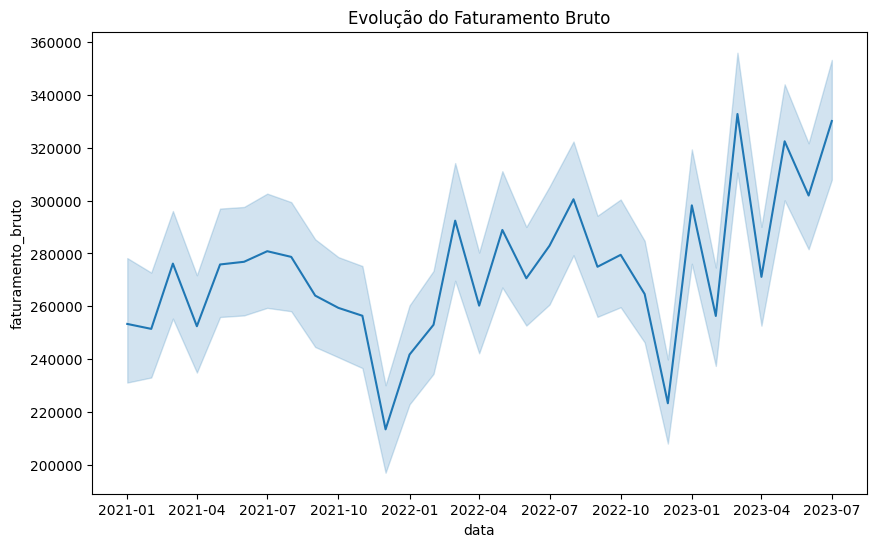

In [14]:
# Convert 'Date' column to datetime
df_c['data'] = pd.to_datetime(df_c['data'])

# Plot the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(x='data', y='faturamento_bruto', data=df_c)

# Set labels and title
plt.xlabel('data')
plt.ylabel('faturamento_bruto')
plt.title('Evolução do Faturamento Bruto')

# Show the plot
plt.show()

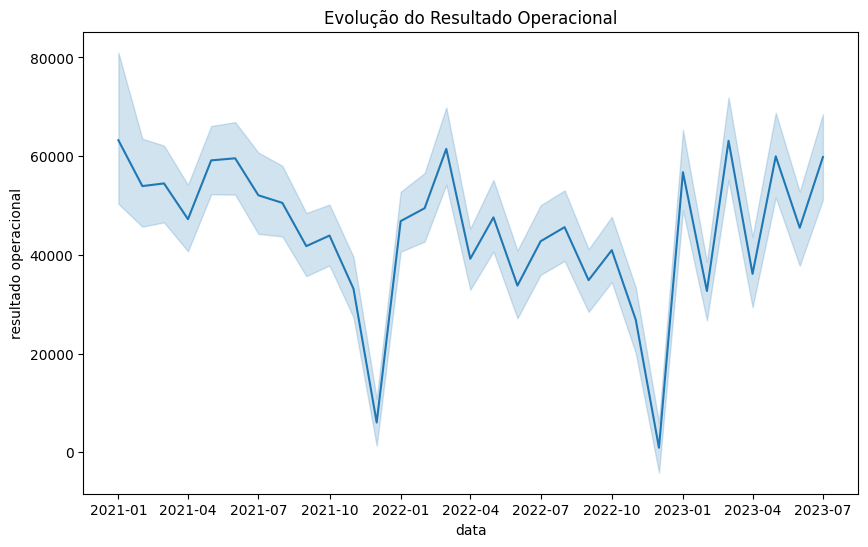

In [15]:
# Convert 'Date' column to datetime
df_c['data'] = pd.to_datetime(df_c['data'])

# Plot the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(x='data', y='resultado_operacional', data=df_c)

# Set labels and title
plt.xlabel('data')
plt.ylabel('resultado operacional')
plt.title('Evolução do Resultado Operacional')

# Show the plot
plt.show()

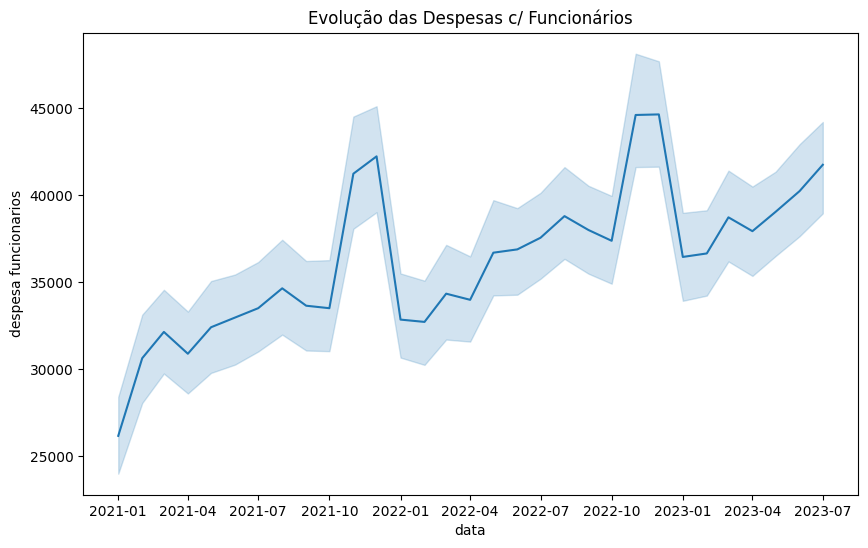

In [16]:
# Convert 'Date' column to datetime
df_c['data'] = pd.to_datetime(df_c['data'])

# Plot the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(x='data', y='despesa_funcionarios', data=df_c)

# Set labels and title
plt.xlabel('data')
plt.ylabel('despesa funcionarios')
plt.title('Evolução das Despesas c/ Funcionários')

# Show the plot
plt.show()

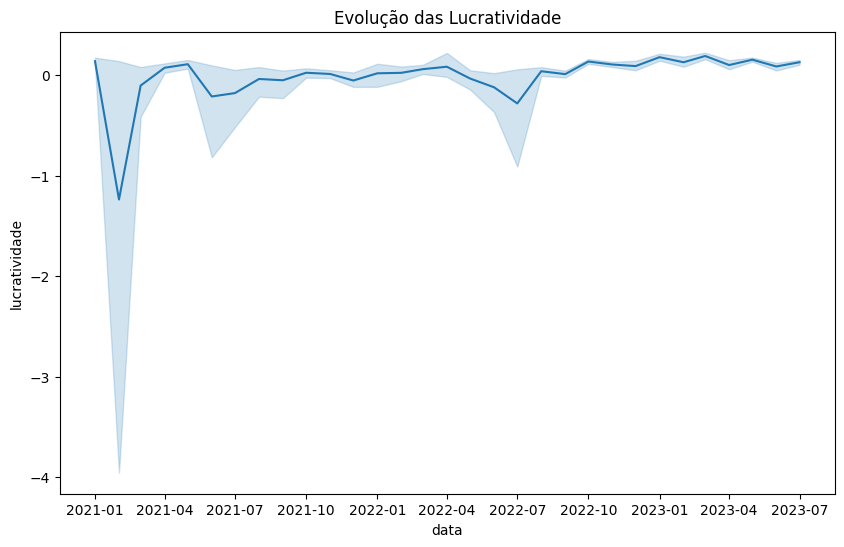

In [17]:
# multiplicando lucratividade por 100
#df_c['lucratividade'] = df_c['lucratividade']*100

# Plot the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(x='data', y='lucratividade', data=df_c)

# Set labels and title
plt.xlabel('data')
plt.ylabel('lucratividade')
plt.title('Evolução das Lucratividade')

# Show the plot
plt.show()

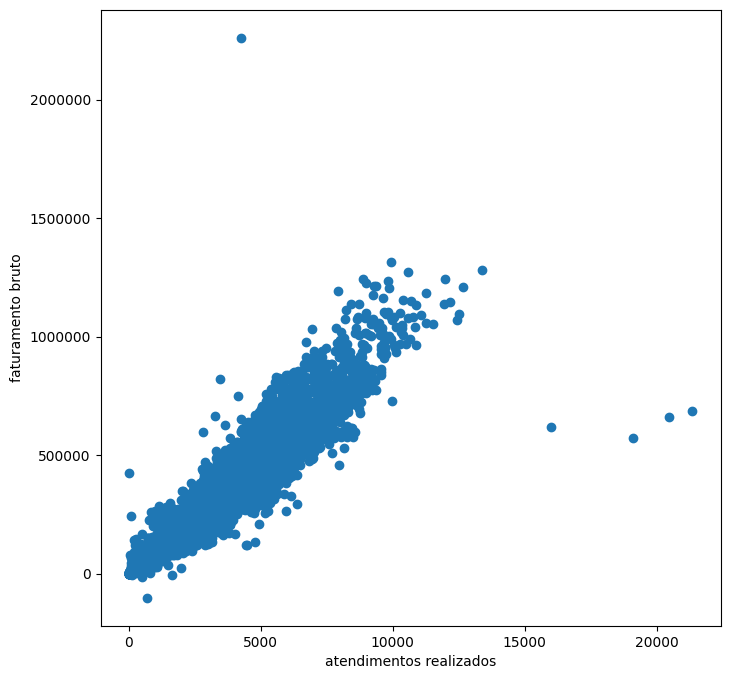

In [18]:
# plotando gráfico dispersão
fig = plt.figure(figsize=(8,8))
plt.scatter(df_c['qtd_atendimentos'],
            df_c['faturamento_bruto']);
plt.xlabel('atendimentos realizados');
plt.ylabel('faturamento bruto');

# formatando rótulos do eixo y
plt.ticklabel_format(style='plain', axis='y')

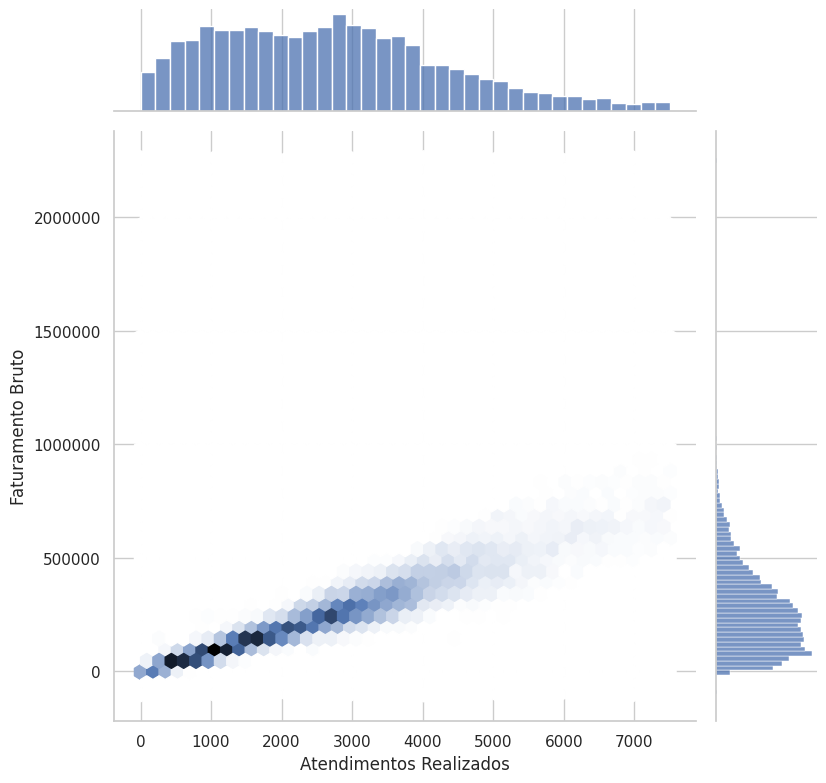

In [19]:
# plotando gráfico de dispersão hexagonal
sns.set(style="whitegrid")  # Define o estilo dos gráficos do Seaborn

# Define your dataset df_c and calculate the IQR
q1 = df_c['qtd_atendimentos'].quantile(0.25)
q3 = df_c['qtd_atendimentos'].quantile(0.75)
iqr = q3 - q1

# Define the upper and lower bounds for outlier detection
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered_df = df_c[(df_c['qtd_atendimentos'] >= lower_bound) & (df_c['qtd_atendimentos'] <= upper_bound)]
# Create the hexbin plot
sns.set(style="whitegrid")
g = sns.jointplot(data=filtered_df, x='qtd_atendimentos', y='faturamento_bruto', kind='hex', height=8)
g.set_axis_labels('Atendimentos Realizados', 'Faturamento Bruto')
g.ax_joint.ticklabel_format(style='plain', axis='y')
plt.show()

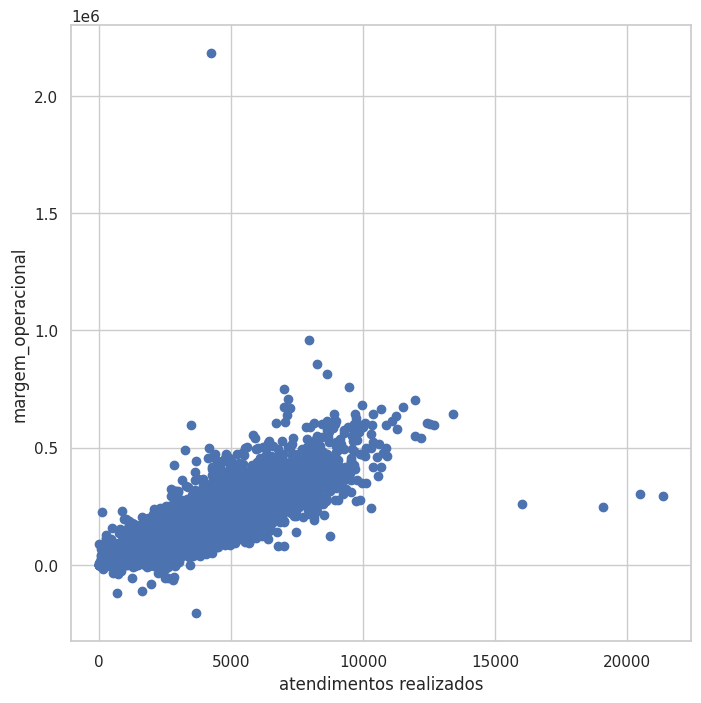

In [20]:
# plotando gráfico dispersão
fig = plt.figure(figsize=(8,8))
plt.scatter(df_c['qtd_atendimentos'],
            df_c['margem_op']);
plt.xlabel('atendimentos realizados');
plt.ylabel('margem_operacional');

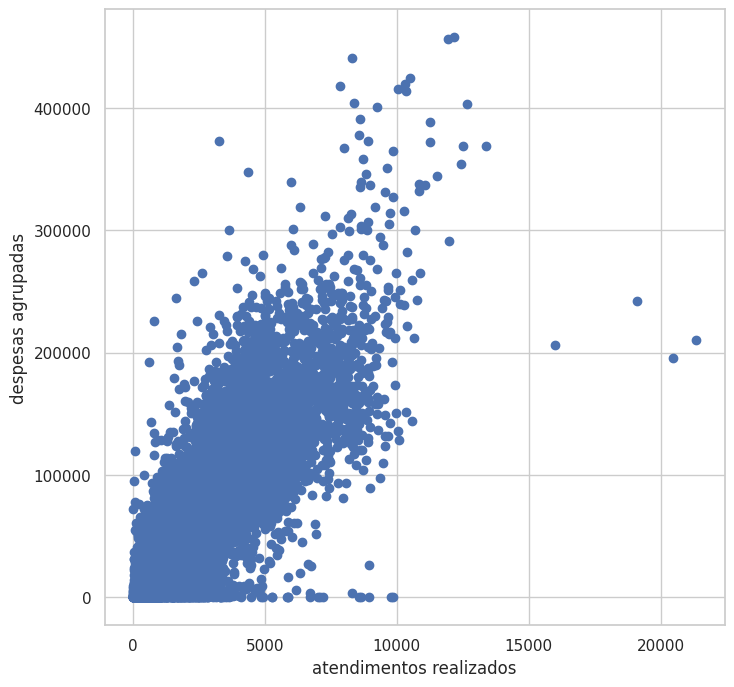

In [21]:
# plotando gráfico dispersão
fig = plt.figure(figsize=(8,8))
plt.scatter(df_c['qtd_atendimentos'],
            df_c['despesas_agrupadas']);
plt.xlabel('atendimentos realizados');
plt.ylabel('despesas agrupadas');

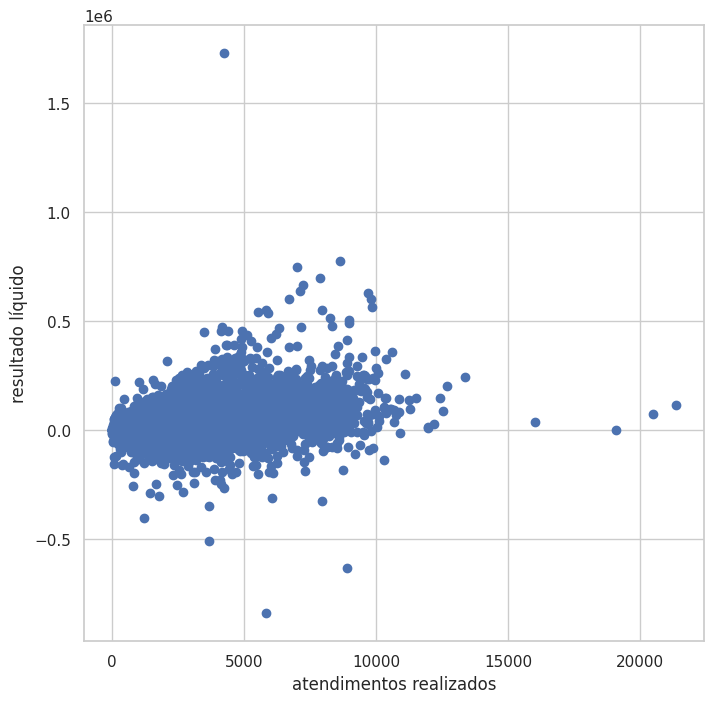

In [22]:
# plotando gráfico dispersão
fig = plt.figure(figsize=(8,8))
plt.scatter(df_c['qtd_atendimentos'],
            df_c['resultado_liquido']);
plt.xlabel('atendimentos realizados');
plt.ylabel('resultado líquido');

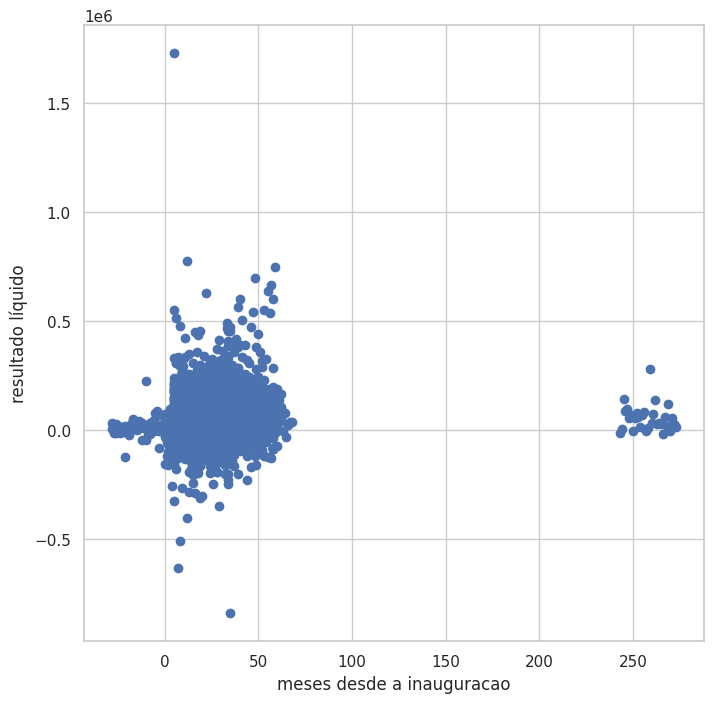

In [23]:
# plotando gráfico dispersão
fig = plt.figure(figsize=(8,8))
plt.scatter(df_c['meses_inauguracao'],
            df_c['resultado_liquido']);
plt.xlabel('meses desde a inauguracao');
plt.ylabel('resultado líquido');

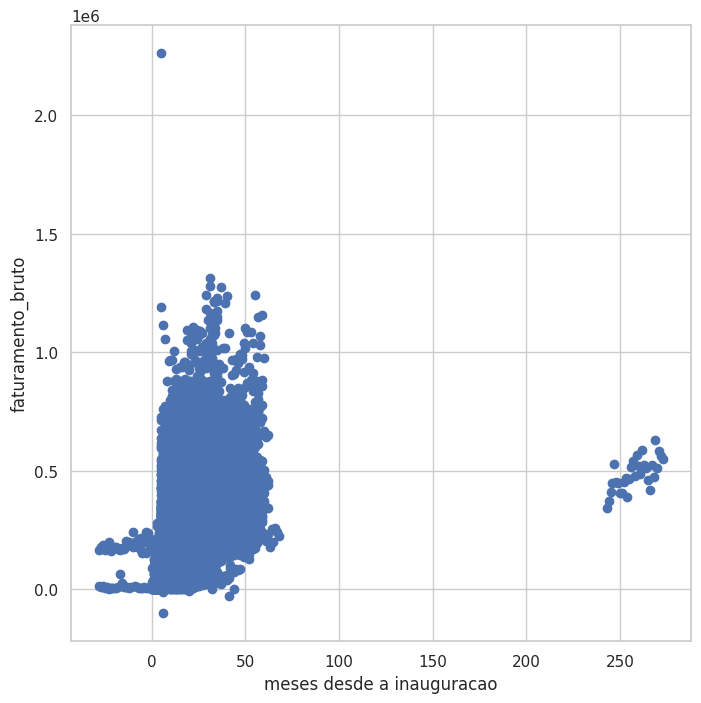

In [24]:
# plotando gráfico dispersão
fig = plt.figure(figsize=(8,8))
plt.scatter(df_c['meses_inauguracao'],
            df_c['faturamento_bruto']);
plt.xlabel('meses desde a inauguracao');
plt.ylabel('faturamento_bruto');


## plotando matriz de correlação

In [25]:
# reduzindo colunas do df_c para facilitar visualização

df_matrix = df_c[['faturamento_bruto', 'royalties', 'royalties_split', 'repasse_consultas',
                  'repasse_exames','repasse_procedimentos','repasses','margem_op','despesa_medicos','despesa_lab',
                  'despesa_outrosp','despesa_funcionarios','despesa_impostos','despesa_adm','resultado_operacional',
                  'qtd_agendamentos','qtd_atendimentos','meses_inauguracao', 'tx_conversao']]

correlation_matrix = df_matrix.corr()

correlation_matrix

,faturamento_bruto,royalties,royalties_split,repasse_consultas,repasse_exames,repasse_procedimentos,repasses,margem_op,despesa_medicos,despesa_lab,despesa_outrosp,despesa_funcionarios,despesa_impostos,despesa_adm,resultado_operacional,qtd_agendamentos,qtd_atendimentos,meses_inauguracao,tx_conversao
faturamento_bruto,1.000000,0.601846,-0.536581,0.436652,0.562939,0.269556,0.590530,0.940312,0.114845,0.224125,0.073281,0.781469,0.582475,0.651030,0.700951,0.936359,0.941902,0.318261,0.010207
royalties,0.601846,1.000000,-0.425622,0.246516,0.337337,0.193416,0.403638,0.493828,0.049489,0.127463,0.007646,0.498727,0.406786,0.382331,0.300168,0.575067,0.563779,0.217723,-0.044273
royalties_split,-0.536581,-0.425622,1.000000,-0.128955,-0.215432,-0.180880,-0.405703,-0.481221,-0.024143,-0.153110,0.013563,-0.436015,-0.384139,-0.350276,-0.318731,-0.508624,-0.452831,-0.338692,0.198223
repasse_consultas,0.436652,0.246516,-0.128955,1.000000,0.570867,0.340161,-0.363146,0.373086,0.055236,0.113897,0.051393,0.355541,0.214789,0.333211,0.237064,0.431782,0.454283,0.096948,0.052421
repasse_exames,0.562939,0.337337,-0.215432,0.570867,1.000000,0.198953,-0.020884,0.404408,0.062228,-0.076721,0.057217,0.478403,0.274773,0.454542,0.219617,0.509334,0.532329,0.146155,0.062790
repasse_procedimentos,0.269556,0.193416,-0.180880,0.340161,0.198953,1.000000,-0.078924,0.222686,0.022823,0.042081,0.006227,0.252147,0.273211,0.193385,0.098927,0.264037,0.242483,0.141170,-0.073364
repasses,0.590530,0.403638,-0.405703,-0.363146,-0.020884,-0.078924,1.000000,0.493648,0.002079,0.100254,0.015545,0.466456,0.387683,0.350586,0.334515,0.586424,0.571441,0.216941,-0.032388
margem_op,0.940312,0.493828,-0.481221,0.373086,0.404408,0.222686,0.493648,1.000000,0.159576,0.299810,0.080669,0.705753,0.535269,0.584007,0.829469,0.848841,0.856134,0.296236,0.013348
despesa_medicos,0.114845,0.049489,-0.024143,0.055236,0.062228,0.022823,0.002079,0.159576,1.000000,0.049324,0.046113,0.092936,0.061576,0.071276,0.055878,0.073924,0.093257,-0.012835,0.070513
despesa_lab,0.224125,0.127463,-0.153110,0.113897,-0.076721,0.042081,0.100254,0.299810,0.049324,1.000000,0.027936,0.199616,0.174674,0.166453,0.093945,0.197179,0.197764,0.122921,-0.004400


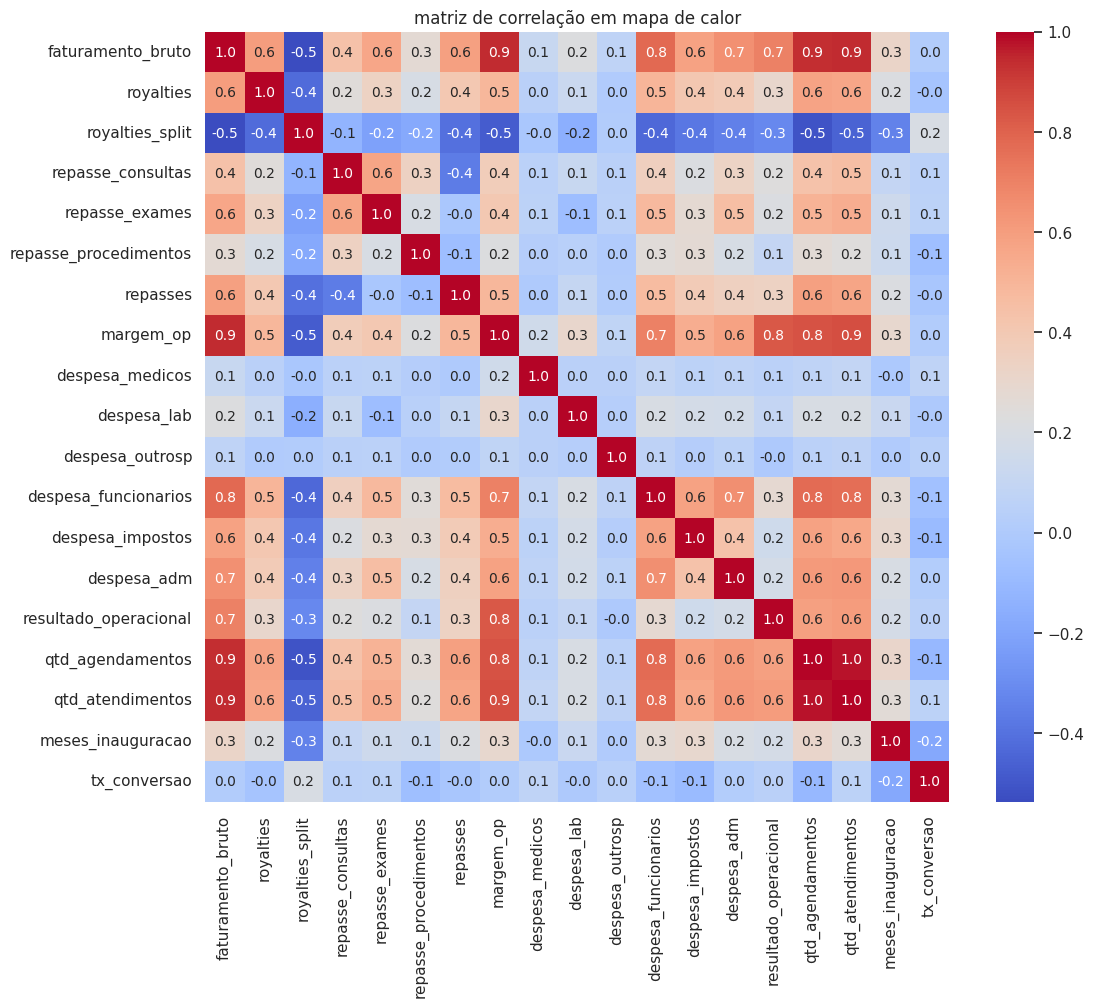

In [26]:
# setando tamanho da figura

plt.figure(figsize=(12,10))

# criando heatmap com o seaborn

sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='coolwarm', annot_kws={"fontsize": 10})

# customizando o plot

plt.title('matriz de correlação em mapa de calor')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# mostrando o plot

plt.show()

In [27]:
# reduzindo colunas do df_c para facilitar visualização

df_correl = df_c[['faturamento_bruto', 'royalties', 'royalties_split', 'repasse_consultas', 'repasse_exames',
       'repasse_procedimentos', 'repasses', 'margem_op', 'despesa_medicos',
       'despesa_lab', 'despesa_outrosp', 'despesa_funcionarios', 'despesa_impostos', 'despesa_adm', 'despesas_agrupadas',
       'resultado_operacional', 'resultado_exercicio',
       'resultado_liquido', 'qtd_atendimentos',
       'meses_inauguracao', 'tx_conversao']]

df_correl['royalties_total'] = - (df_correl['royalties'] + df_correl['royalties_split'])
df_correl.drop(['royalties', 'royalties_split'], axis=1, inplace=True)
df_correl['repasses_total'] = - (df_correl['repasse_consultas'] + df_correl['repasse_exames'] + df_correl['repasse_procedimentos'] + df_correl['repasses'])
df_correl.drop(['repasse_consultas', 'repasse_exames', 'repasse_procedimentos', 'repasses'], axis=1, inplace=True)
df_correl['outras_despesas_operacionais'] = - (df_correl['despesa_medicos'] + df_correl['despesa_lab'] + df_correl['despesa_outrosp'])
df_correl.drop(['despesa_medicos', 'despesa_lab', 'despesa_outrosp'], axis=1, inplace=True)
df_correl['despesa_funcionarios'] = - (df_correl['despesa_funcionarios'])
df_correl['despesa_impostos'] = - (df_correl['despesa_impostos'])
df_correl['despesa_adm'] = - (df_correl['despesa_adm'])
df_correl['despesas_agrupadas'] = - (df_correl['despesas_agrupadas'])

corr_slide = df_correl.corr()

corr_slide

/tmp/ipykernel_28055/3847197311.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correl['royalties_total'] = - (df_correl['royalties'] + df_correl['royalties_split'])
/tmp/ipykernel_28055/3847197311.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correl.drop(['royalties', 'royalties_split'], axis=1, inplace=True)
/tmp/ipykernel_28055/3847197311.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

,faturamento_bruto,margem_op,despesa_funcionarios,despesa_impostos,despesa_adm,despesas_agrupadas,resultado_operacional,resultado_exercicio,resultado_liquido,qtd_atendimentos,meses_inauguracao,tx_conversao,royalties_total,repasses_total,outras_despesas_operacionais
faturamento_bruto,1.000000,0.940312,-0.781469,-0.582475,-0.651030,-0.807586,0.700951,0.620436,0.472564,0.941902,0.318261,0.010207,-0.284964,-0.934536,-0.253909
margem_op,0.940312,1.000000,-0.705753,-0.535269,-0.584007,-0.730871,0.829469,0.753615,0.619175,0.856134,0.296236,0.013348,-0.206048,-0.760054,-0.337192
despesa_funcionarios,-0.781469,-0.705753,1.000000,0.585666,0.651877,0.910168,-0.285380,-0.228377,-0.125938,-0.762364,-0.272355,0.056911,0.241991,0.760149,0.222515
despesa_impostos,-0.582475,-0.535269,0.585666,1.000000,0.431532,0.770279,-0.153317,-0.139240,-0.096354,-0.560452,-0.294013,0.092489,0.178047,0.551706,0.176265
despesa_adm,-0.651030,-0.584007,0.651877,0.431532,1.000000,0.832856,-0.174854,-0.126311,-0.052486,-0.621145,-0.198897,-0.015643,0.174648,0.640376,0.184099
despesas_agrupadas,-0.807586,-0.730871,0.910168,0.770279,0.832856,1.000000,-0.250824,-0.200931,-0.110636,-0.779887,-0.300904,0.050965,0.238855,0.783375,0.232911
resultado_operacional,0.700951,0.829469,-0.285380,-0.153317,-0.174854,-0.250824,1.000000,0.928004,0.804114,0.606323,0.181284,0.049907,-0.107456,-0.481450,-0.099864
resultado_exercicio,0.620436,0.753615,-0.228377,-0.139240,-0.126311,-0.200931,0.928004,1.000000,0.868723,0.526583,0.171179,0.040960,-0.078638,-0.406838,-0.096704
resultado_liquido,0.472564,0.619175,-0.125938,-0.096354,-0.052486,-0.110636,0.804114,0.868723,1.000000,0.384967,0.141123,-0.002232,-0.031621,-0.262175,-0.080492
qtd_atendimentos,0.941902,0.856134,-0.762364,-0.560452,-0.621145,-0.779887,0.606323,0.526583,0.384967,1.000000,0.258260,0.060074,-0.300652,-0.914076,-0.220419


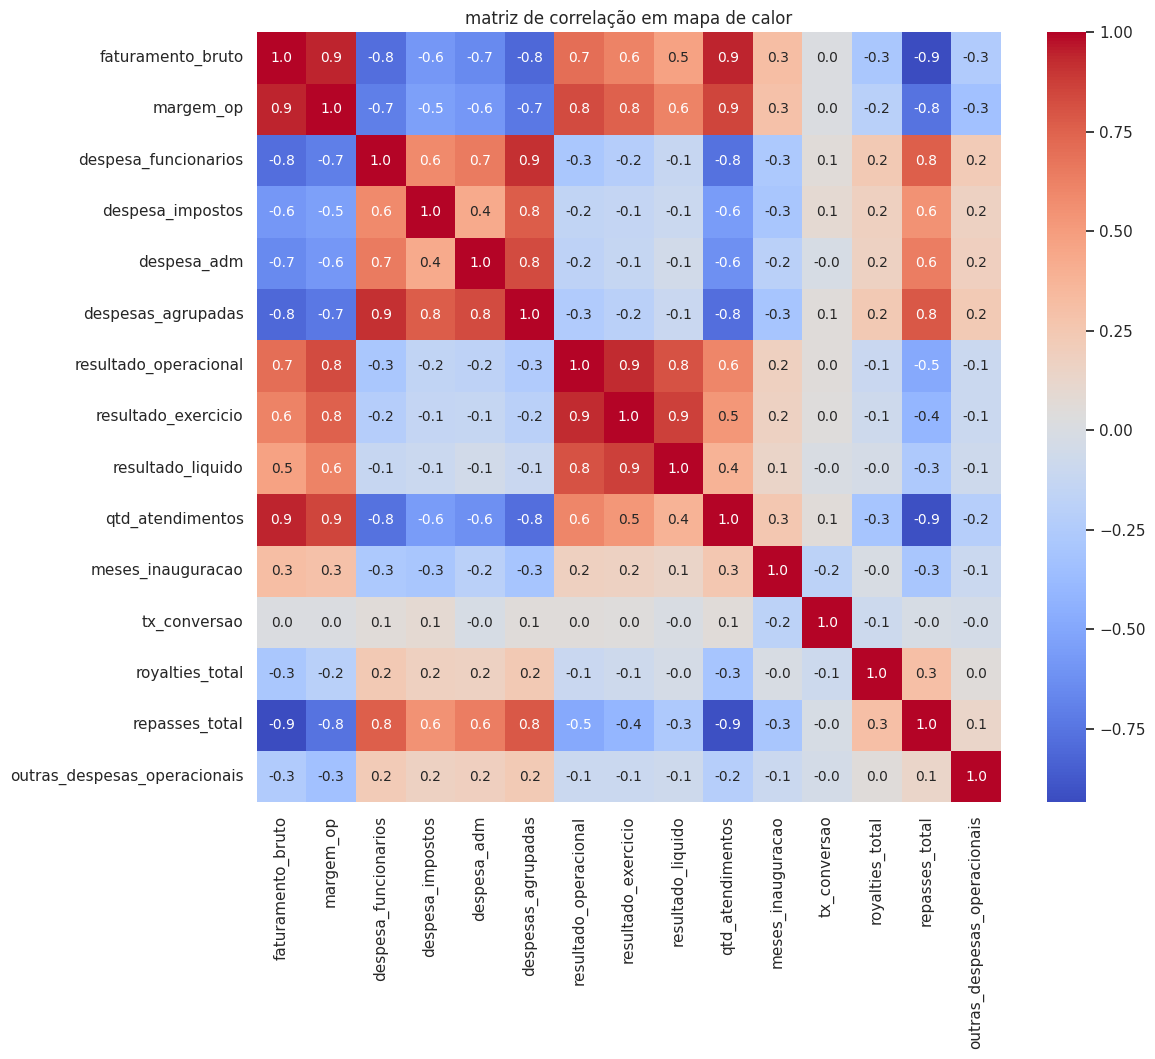

In [28]:
# setando tamanho da figura

plt.figure(figsize=(12, 10))

# criando heatmap com o seaborn

sns.heatmap(corr_slide, annot=True, fmt='.1f', cmap='coolwarm', annot_kws={"fontsize": 10})

# customizando o plot

plt.title('matriz de correlação em mapa de calor')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# mostrando o plot

plt.show()

In [29]:
print('''Correlação positiva:

Um coeficiente de correlação de 0,1 a 0,3 indica uma correlação positiva fraca.
Um coeficiente de correlação de 0,3 a 0,5 indica uma correlação positiva moderada.
Um coeficiente de correlação de 0,5 a 1,0 indica uma correlação positiva forte.
Correlação negativa:

Um coeficiente de correlação de -0,1 a -0,3 indica uma correlação negativa fraca.
Um coeficiente de correlação de -0,3 a -0,5 indica uma correlação negativa moderada.
Um coeficiente de correlação de -0,5 a -1,0 indica uma correlação negativa forte.''')

Correlação positiva:

Um coeficiente de correlação de 0,1 a 0,3 indica uma correlação positiva fraca.
Um coeficiente de correlação de 0,3 a 0,5 indica uma correlação positiva moderada.
Um coeficiente de correlação de 0,5 a 1,0 indica uma correlação positiva forte.
Correlação negativa:

Um coeficiente de correlação de -0,1 a -0,3 indica uma correlação negativa fraca.
Um coeficiente de correlação de -0,3 a -0,5 indica uma correlação negativa moderada.
Um coeficiente de correlação de -0,5 a -1,0 indica uma correlação negativa forte.


## clusterização por K-Means

In [30]:
# seleção das variáveis

df_modelo = df_c[['faturamento_bruto','qtd_atendimentos']].copy()
df_modelo = df_modelo.dropna()

# padronização escala
x_scaler = StandardScaler()
x_scaler.fit(df_modelo)

df_modelo_scaled = pd.DataFrame(x_scaler.transform(df_modelo),
                                index=df_modelo.index,
                                columns=df_modelo.columns)

# descrevendo os df 

df_modelo.describe()
#df_modelo_scaled.describe()

,faturamento_bruto,qtd_atendimentos
count,1.119200e+04,11192.000000
mean,2.754758e+05,2899.820407
std,2.001708e+05,1939.590221
min,-1.015006e+05,1.000000
25%,1.257445e+05,1433.750000
50%,2.393825e+05,2664.000000
75%,3.724443e+05,3865.250000
max,2.261060e+06,21360.000000


In [31]:
# estipulando clusters no modelo

modelo_km = KMeans(n_clusters=2,
                   random_state=42)
modelo_km.fit(df_modelo_scaled)

KMeans(n_clusters=2, random_state=42)

In [32]:
# análise dos clusters
cluster_predito = modelo_km.predict(df_modelo_scaled)
cluster_predito

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [33]:
modelo_km.cluster_centers_

array([[ 1.22531488,  1.19292572],
       [-0.50994061, -0.49646118]])

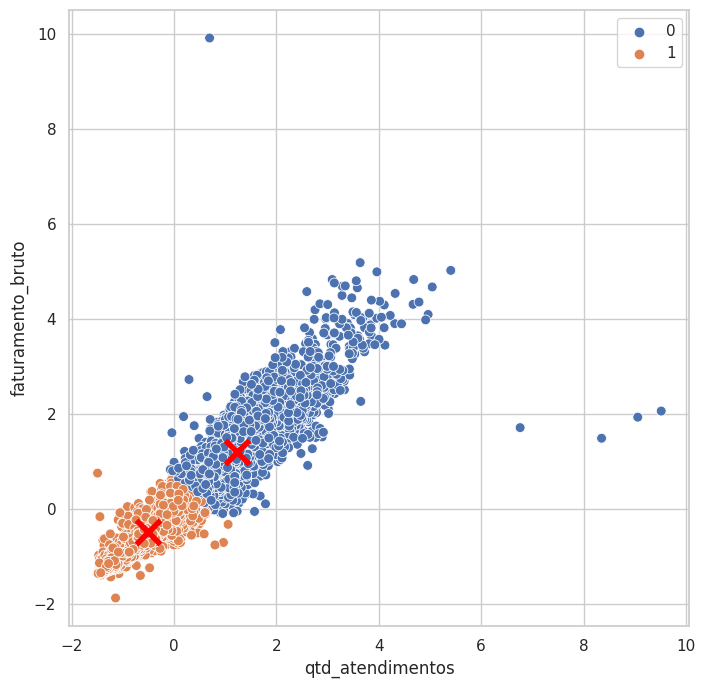

In [34]:
fig = plt.figure(figsize=(8,8))

# plotando resultado por agendamento
sns.scatterplot(x=df_modelo_scaled['qtd_atendimentos'],
                y=df_modelo_scaled['faturamento_bruto'],
                hue=cluster_predito, s=50)

# plotando resultado por despesa
sns.scatterplot(x=modelo_km.cluster_centers_[:,0],
                y=modelo_km.cluster_centers_[:,1], 
                marker='x', s=300, 
                linewidth=4, color='red', zorder=10);

In [35]:
# calculando inércia

modelo_km.inertia_

8756.135648145055

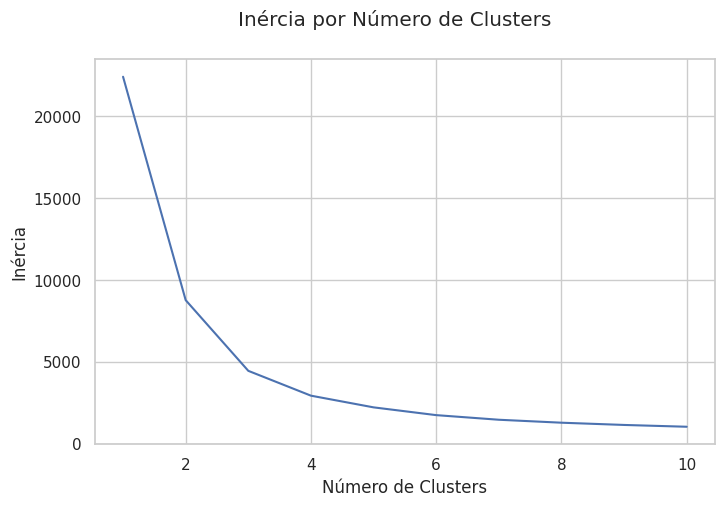

In [36]:
# utilizando método do cotovelo (elbow curve)

range_n_clusters = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
inercia = []

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_modelo_scaled)
    inercia.append(kmeans.inertia_)

fig = plt.figure(figsize=(8,5))
graf = sns.lineplot(x=range_n_clusters,
             y=inercia)
graf.figure.suptitle('Inércia por Número de Clusters');
graf.set_xlabel('Número de Clusters');
graf.set_ylabel('Inércia');

In [37]:
modelo_km3 = KMeans(n_clusters=3,
                    random_state=42)
modelo_km3.fit(df_modelo_scaled)

KMeans(n_clusters=3, random_state=42)

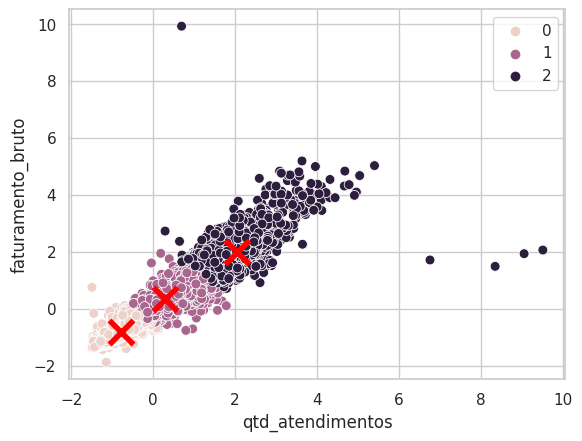

In [38]:
# análise dos novos clusters

cluster_predito = modelo_km3.predict(df_modelo_scaled)

# plotando resultado por agendamento
sns.scatterplot(x=df_modelo_scaled['qtd_atendimentos'],
                y=df_modelo_scaled['faturamento_bruto'],
                hue=cluster_predito, s=50)

# marcando os centróides
sns.scatterplot(x=modelo_km3.cluster_centers_[:,0],
                y=modelo_km3.cluster_centers_[:,1], 
                marker='x', s=300, 
                linewidth=4, color='red', zorder=10);

In [39]:
# interpretação e caracterização dos clusters

df_modelo['cluster'] = modelo_km3.predict(df_modelo_scaled)

In [40]:
df_modelo.groupby('cluster').describe().T

cluster                              0              1             2
faturamento_bruto count    5091.000000    4809.000000  1.292000e+03
                  mean   115978.000560  334584.882077  6.839495e+05
                  std     62548.452942   84199.555411  1.587092e+05
                  min   -101500.600000  122150.400000  4.128169e+05
                  25%     67286.430000  266531.060000  5.724929e+05
                  50%    115274.590000  321370.100000  6.494751e+05
                  75%    166544.160000  393261.160000  7.545318e+05
                  max    425294.240000  663849.300000  2.261060e+06
qtd_atendimentos  count    5091.000000    4809.000000  1.292000e+03
                  mean     1322.304459    3543.832190  6.718769e+03
                  std       678.947183     771.616834  1.619234e+03
                  min         1.000000    1968.000000  3.466000e+03
                  25%       780.500000    2922.000000  5.581250e+03
                  50%      1321.000000    3436.000000  6.386000e+03
                  75%      1867.500000    4057.000000  7.632500e+03
                  max      3145.000000    6364.000000  2.136000e+04

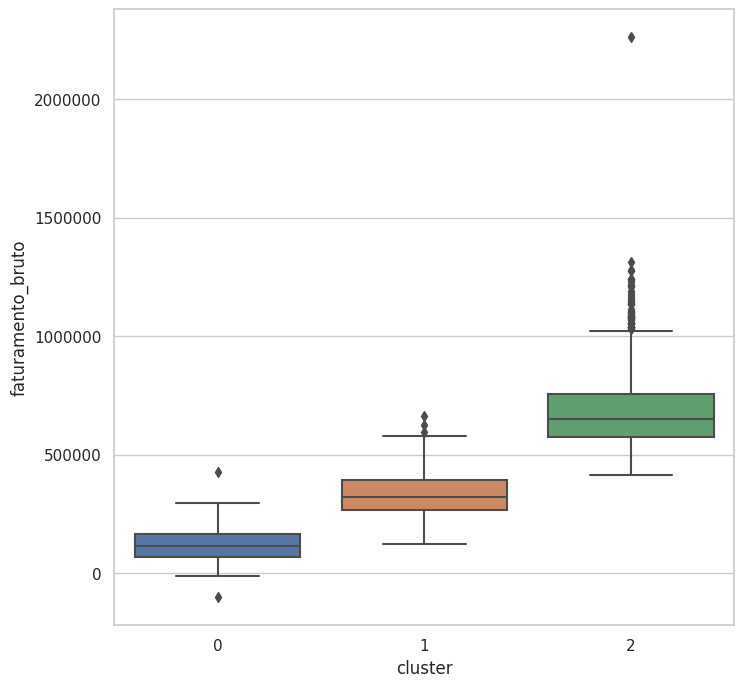

In [41]:
# análise dos clusters em relação a faturamento_bruto

fig = plt.figure(figsize=(8,8))
sns.boxplot(x='cluster',
            y='faturamento_bruto',
            data=df_modelo);
plt.ticklabel_format(style='plain', axis='y')

In [42]:
# inserindo coluna de cluster no df completo

df_c['cluster'] = df_modelo['cluster']

# criando df para analise descritiva 

df_analise = df_c[['margem_op', '%_funcionarios', '%_impostos', '%_adm', 'resultado_operacional', 'cluster']]

# Set the float format option to display normal values
pd.options.display.float_format = '{:.2f}'.format

df_analise.groupby('cluster').describe().T

cluster                           0.00       1.00       2.00
margem_op             count    5091.00    4809.00    1292.00
                      mean    56158.24  165119.69  335544.18
                      std     36510.36   59772.08  116177.77
                      min   -121200.00 -207678.27   80214.53
                      25%     28696.33  123420.48  267482.39
                      50%     53291.29  157834.02  318485.83
                      75%     79671.86  201539.85  380466.53
                      max    227624.45  490463.72 2183919.43
%_funcionarios        count    5001.00    4808.00    1292.00
                      mean        1.58       0.30       0.25
                      std        47.48       0.17       0.11
                      min         0.00       0.00       0.00
                      25%         0.22       0.20       0.18
                      50%         0.35       0.27       0.23
                      75%         0.55       0.36       0.29
                      max      3116.54       4.39       1.23
%_impostos            count    5001.00    4808.00    1292.00
                      mean        0.33       0.13       0.12
                      std         9.12       0.12       0.09
                      min         0.00       0.00       0.00
                      25%         0.00       0.05       0.05
                      50%         0.06       0.10       0.10
                      75%         0.18       0.18       0.16
                      max       625.78       1.69       0.60
%_adm                 count    5001.00    4808.00    1292.00
                      mean        2.08       0.22       0.18
                      std        64.85       0.14       0.10
                      min         0.00       0.00       0.00
                      25%         0.17       0.15       0.12
                      50%         0.29       0.20       0.16
                      75%         0.47       0.27       0.22
                      max      4147.15       2.63       0.90
resultado_operacional count    5091.00    4809.00    1292.00
                      mean     7589.25   55395.22  149024.52
                      std     35127.49   57903.75  112360.32
                      min   -186554.77 -365532.57 -126861.35
                      25%    -11239.99   19055.75   88346.65
                      50%      4479.34   51807.71  137187.15
                      75%     23981.38   88304.87  194749.40
                      max    225813.02  458972.37 1959678.18

In [43]:
# exportando df para arquivo xlsx

df_c.to_excel('estudo_percentual_despesas.xlsx', sheet_name='base', index=False)

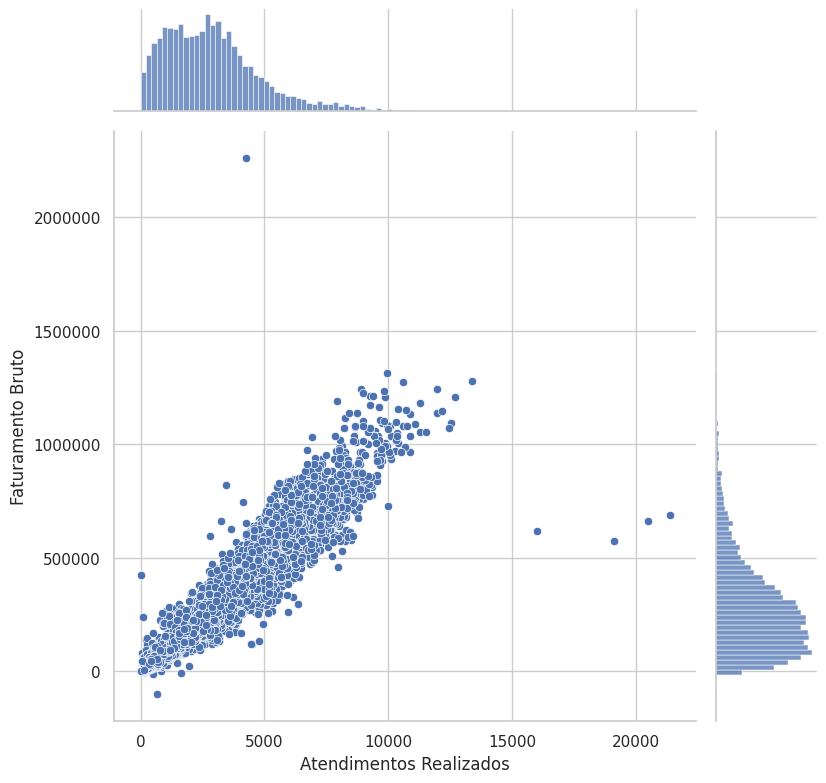

In [44]:
# plotando gráfico de dispersão hexagonal
sns.set(style="whitegrid")  # Define o estilo dos gráficos do Seaborn

# Create the hexbin plot
sns.set(style="whitegrid")
g = sns.jointplot(data=df_c, x='qtd_atendimentos', y='faturamento_bruto', kind='scatter', height=8)
g.set_axis_labels('Atendimentos Realizados', 'Faturamento Bruto')
g.ax_joint.ticklabel_format(style='plain', axis='y')
plt.show()

## manipulações no df completo

In [45]:
# agrupando dados por mês

df_c['data'] = pd.to_datetime(df_c['data']).dt.date

df_data = df_c.groupby('data')[['margem_op', 'despesa_funcionarios', 'despesa_impostos', 'despesa_adm', 'resultado_operacional']].sum()

# exibindo o df 

#df_data

In [46]:
# agrupando dados por hierarquias de data

df_c['ano'] = pd.to_datetime(df_c['data']).dt.year
df_c['mes'] = pd.to_datetime(df_c['data']).dt.month

df_ano = df_c.groupby('ano')[['margem_op', 'despesa_funcionarios', 'despesa_impostos', 'despesa_adm', 'resultado_operacional']].sum()

# exibindo o df

#df_ano

In [47]:
#df_c.columns

In [48]:
df_abs = df_c[['data','ano', 'regiao', 'faturamento_bruto', 'margem_op', 'despesa_funcionarios', 'despesa_adm', 'despesa_impostos', 'resultado_operacional', 'cluster']]

In [49]:
# estatística descritiva agrupada por ano

df_abs.groupby(['ano']).describe().T

ano                               2021       2022       2023
faturamento_bruto     count    3719.00    4555.00    2931.00
                      mean   261282.38  269434.53  301958.14
                      std    182697.55  198487.51  220688.71
                      min    -12845.00 -101500.60     612.20
                      25%    124055.08  114318.89  140558.55
                      50%    236412.47  232899.04  247853.91
                      75%    353567.04  370874.95  405490.49
                      max   2261059.97 1134568.80 1313305.40
margem_op             count    3719.00    4555.00    2931.00
                      mean   128789.97  130268.29  150605.99
                      std    102782.51  102787.41  118585.50
                      min    -55010.26 -121200.00 -207678.27
                      25%     56428.73   52878.78   62659.73
                      50%    110785.82  107666.91  120797.22
                      75%    179787.48  183141.08  207006.35
                      max   2183919.43  674373.91  749731.77
despesa_funcionarios  count    3719.00    4555.00    2931.00
                      mean    33877.99   37530.14   38693.41
                      std     24153.74   26900.18   27151.14
                      min         0.00       0.00       0.00
                      25%     16345.62   18580.43   20478.35
                      50%     31583.29   34092.15   35015.97
                      75%     46910.08   51002.93   52071.17
                      max    256883.23  274111.43  271015.93
despesa_adm           count    3719.00    4555.00    2931.00
                      mean    28134.01   28640.97   29381.14
                      std     22920.45   21544.06   21146.63
                      min         0.00       0.00       0.00
                      25%     13629.90   14491.92   14787.44
                      50%     24716.86   25051.87   25528.66
                      75%     37087.68   37934.82   40153.81
                      max    302847.50  350179.47  187179.25
despesa_impostos      count    3719.00    4555.00    2931.00
                      mean    11061.53   16489.53   19802.56
                      std     14620.03   19117.33   21416.66
                      min         0.00       0.00       0.00
                      25%       343.33    2602.66    4915.06
                      50%      5804.78   10334.63   13326.89
                      75%     15925.70   23067.44   27458.73
                      max    134440.97  147466.52  182525.82
resultado_operacional count    3719.00    4555.00    2931.00
                      mean    46415.39   38713.21   50574.81
                      std     72766.95   67232.49   82407.27
                      min   -186554.77 -224344.35 -365532.57
                      25%      2022.93   -3185.46    1025.32
                      50%     31557.25   22596.28   30278.28
                      75%     75773.99   68582.91   84653.71
                      max   1959678.18  507062.13  749058.77
cluster               count    3714.00    4551.00    2927.00
                      mean        0.65       0.66       0.68
                      std         0.65       0.68       0.70
                      min         0.00       0.00       0.00
                      25%         0.00       0.00       0.00
                      50%         1.00       1.00       1.00
                      75%         1.00       1.00       1.00
                      max         2.00       2.00       2.00

In [50]:
# estatística descritiva agrupada por cluster
df_abs = df_abs.drop(['ano'], axis=1)
df_abs.groupby(['cluster']).describe().T

cluster                           0.00       1.00       2.00
faturamento_bruto     count    5091.00    4809.00    1292.00
                      mean   115978.00  334584.88  683949.53
                      std     62548.45   84199.56  158709.18
                      min   -101500.60  122150.40  412816.90
                      25%     67286.43  266531.06  572492.87
                      50%    115274.59  321370.10  649475.14
                      75%    166544.16  393261.16  754531.83
                      max    425294.24  663849.30 2261059.97
margem_op             count    5091.00    4809.00    1292.00
                      mean    56158.24  165119.69  335544.18
                      std     36510.36   59772.08  116177.77
                      min   -121200.00 -207678.27   80214.53
                      25%     28696.33  123420.48  267482.39
                      50%     53291.29  157834.02  318485.83
                      75%     79671.86  201539.85  380466.53
                      max    227624.45  490463.72 2183919.43
despesa_funcionarios  count    5091.00    4809.00    1292.00
                      mean    19396.07   43962.28   77312.44
                      std     13082.14   17588.24   32802.09
                      min         0.00       0.00       0.00
                      25%      9881.94   34074.19   59550.56
                      50%     19117.98   43556.19   72734.04
                      75%     27339.80   53756.90   91103.98
                      max     90048.37  145839.46  274111.43
despesa_adm           count    5091.00    4809.00    1292.00
                      mean    16690.44   33815.26   56865.12
                      std     14050.35   17562.29   27844.10
                      min         0.00       0.00       0.00
                      25%      7954.11   23743.17   40594.87
                      50%     14835.66   31376.64   51035.38
                      75%     22324.64   41229.02   67625.46
                      max    218050.76  302847.50  350179.47
despesa_impostos      count    5091.00    4809.00    1292.00
                      mean     6199.59   19815.74   36592.33
                      std      8473.43   17700.50   27167.14
                      min         0.00       0.00       0.00
                      25%        61.77    7327.96   15672.25
                      50%      3068.28   15719.05   32396.57
                      75%      9138.97   27557.97   51965.65
                      max    106130.19  182395.78  182525.82
resultado_operacional count    5091.00    4809.00    1292.00
                      mean     7589.25   55395.22  149024.52
                      std     35127.49   57903.75  112360.32
                      min   -186554.77 -365532.57 -126861.35
                      25%    -11239.99   19055.75   88346.65
                      50%      4479.34   51807.71  137187.15
                      75%     23981.38   88304.87  194749.40
                      max    225813.02  458972.37 1959678.18

In [51]:
# estatística descritiva agrupada por mês 
#df_abs.groupby(['mes']).describe().T

In [52]:
df_pct = df_c[['data','ano', 'regiao', '%_margem_op', '%_funcionarios', '%_adm', '%_impostos', '%_resultado_op']]
df_pct.groupby(['ano']).describe().T

ano                     2021    2022    2023
%_margem_op    count 3718.00 4554.00 2931.00
               mean     0.49    0.48    0.50
               std      0.18    0.28    0.14
               min      0.00    0.00    0.00
               25%      0.41    0.41    0.43
               50%      0.49    0.48    0.50
               75%      0.56    0.55    0.56
               max      3.63   17.20    3.17
%_funcionarios count 3662.00 4523.00 2925.00
               mean     1.34    0.54    0.78
               std     51.63    3.67   22.31
               min      0.00    0.00    0.00
               25%      0.19    0.21    0.20
               50%      0.27    0.30    0.28
               75%      0.40    0.45    0.40
               max   3116.54  148.76 1206.07
%_adm          count 3662.00 4523.00 2925.00
               mean     2.05    0.51    0.65
               std     74.08    3.95   17.27
               min      0.00    0.00    0.00
               25%      0.15    0.16    0.14
               50%      0.22    0.23    0.20
               75%      0.34    0.35    0.31
               max   4147.15  159.53  930.96
%_impostos     count 3662.00 4523.00 2925.00
               mean     0.09    0.22    0.38
               std      0.21    2.31   11.57
               min      0.00    0.00    0.00
               25%      0.01    0.04    0.06
               50%      0.05    0.10    0.11
               75%      0.12    0.19    0.20
               max      8.28  105.27  625.78
%_resultado_op count 3662.00 4523.00 2925.00
               mean     3.30    0.97    1.61
               std    126.61   10.60   55.68
               min      0.00    0.00    0.00
               25%      0.22    0.20    0.20
               50%      0.39    0.37    0.36
               75%      0.57    0.55    0.54
               max   7426.24  437.55 3009.00

In [53]:
df_pct = df_c[['cluster', '%_margem_op', '%_funcionarios', '%_adm', '%_impostos', '%_resultado_op']]
df_pct.groupby(['cluster']).describe().T

cluster                 0.00    1.00    2.00
%_margem_op    count 5091.00 4809.00 1292.00
               mean     0.49    0.49    0.49
               std      0.30    0.11    0.09
               min      0.00    0.00    0.13
               25%      0.39    0.42    0.43
               50%      0.48    0.49    0.49
               75%      0.57    0.55    0.54
               max     17.20    1.00    1.00
%_funcionarios count 5001.00 4808.00 1292.00
               mean     1.58    0.30    0.25
               std     47.48    0.17    0.11
               min      0.00    0.00    0.00
               25%      0.22    0.20    0.18
               50%      0.35    0.27    0.23
               75%      0.55    0.36    0.29
               max   3116.54    4.39    1.23
%_adm          count 5001.00 4808.00 1292.00
               mean     2.08    0.22    0.18
               std     64.85    0.14    0.10
               min      0.00    0.00    0.00
               25%      0.17    0.15    0.12
               50%      0.29    0.20    0.16
               75%      0.47    0.27    0.22
               max   4147.15    2.63    0.90
%_impostos     count 5001.00 4808.00 1292.00
               mean     0.33    0.13    0.12
               std      9.12    0.12    0.09
               min      0.00    0.00    0.00
               25%      0.00    0.05    0.05
               50%      0.06    0.10    0.10
               75%      0.18    0.18    0.16
               max    625.78    1.69    0.60
%_resultado_op count 5001.00 4808.00 1292.00
               mean     3.76    0.37    0.43
               std    116.82    0.27    0.19
               min      0.00    0.00    0.00
               25%      0.18    0.20    0.32
               50%      0.38    0.35    0.43
               75%      0.73    0.49    0.53
               max   7426.24    6.42    1.19